# TIPP Backtesting Tool


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from datetime import datetime, timedelta, date

from tabulate import tabulate
%matplotlib inline
pdtabulate=lambda df:tabulate(df,headers='keys')
plt.style.use('ggplot')

In [10]:
# Read the cvs with portfolio info and historical data
print("Reading CSVs with portfolio definition and historical data...('TIPP_des.csv','TIPP_BBG.csv','TIPP_OtherDes.csv' & 'TIPP_OtherBBG.csv')")
TIPP_des=pd.read_csv('TIPP_des.csv',index_col='Full Ticker')
mf_prices=pd.read_csv('TIPP_BBG.csv',parse_dates=['Dates'])
mf_prices.set_index('Dates',inplace=True)
other_des = pd.read_csv('TIPP_OtherDes.csv',index_col='Full Ticker')
other_prices = pd.read_csv('TIPP_OtherBBG.csv',parse_dates=['Dates'])
other_prices.set_index('Dates',inplace = True)
print("Done!")

Reading CSVs with portfolio definition and historical data...('TIPP_des.csv','TIPP_BBG.csv','TIPP_OtherDes.csv' & 'TIPP_OtherBBG.csv')
Done!


In [11]:
# express all fund prices in EUR
print("Expressing all prices in EUR...")
mf_names = mf_prices.columns
fx_rate_tck = 'EURUSD Curncy'
mf_prices = mf_prices.join(other_prices[fx_rate_tck],how='left')
for fund in mf_names:
    crncy = TIPP_des.loc[fund,'Crncy']
    if (crncy=='USD'):
        mf_prices[fund]=mf_prices[fund]*mf_prices[fx_rate_tck]
mf_prices.drop(fx_rate_tck,axis = 1,inplace=True)
print("Done!")

Expressing all prices in EUR...
Done!


## Description of the Active Portolio of Mutual Funds 

In [12]:
mf_rets = mf_prices.pct_change()
mf_vols=mf_rets.iloc[-500:,].std()*math.sqrt(250)
TIPP_des['Volatility']=mf_vols
pd.options.display.width=None
#print("Active Portfolio:")
print(pdtabulate(TIPP_des[['LONG COMP NAME','Weight','Multiplier','Volatility']]))
print("\n")
#mf_rets.info()
#print("Other available data:")
#print(other_prices.columns)

# fill back data with proxies
print("replacing missing history with proxy-data...")
mf_names = mf_rets.columns
other_rets=other_prices.pct_change()
for fund in mf_names:
    proxy = TIPP_des.loc[fund,'PROXY Full Ticker']
    null_dates=mf_rets.index[mf_rets[fund].isnull()]
    for ndate in null_dates:
        mf_rets.loc[ndate,fund]=other_rets.loc[ndate,proxy]
#mf_rets.info()
print("Done!")

den=TIPP_des['Weight']/TIPP_des['Multiplier']
max_mult=1/den.sum()
print('\n----------------------------------------------------------------------\nMaxumum Active Portfolio Multiplier = {0:.2f}'.format(max_mult))

Full Ticker        LONG COMP NAME                                                                 Weight    Multiplier    Volatility
-----------------  ---------------------------------------------------------------------------  --------  ------------  ------------
FMGDIAE LX Equity  Franklin Templeton Investment Funds - Franklin Mutual Global Discovery Fund      0.12           6       0.123356
TEMWPIU LX Equity  Franklin Templeton Investment Funds - Franklin World Perspectives Fund           0.12           5.5     0.143902
JPGRECA LX Equity  JPMorgan Funds - Global Research Enhanced Index Equity                           0.12           6       0.124768
INGSGIC LX Equity  NN L Global Sustainable Equity                                                   0.12           6       0.133824
TEMGEIA LX Equity  Templeton Global Climate Change Fund                                             0.12           6       0.115388
TEMEMIA LX Equity  Franklin Templeton Investment Funds - Templeton Emergin

Reminder: $\text{Maximum multiplier} = \frac{1}{\sum_{i=1}^{n}\frac{W_i}{M_i}}$, where $W_i$ is the weight of $i$ fund, and $M_i$ is the multiplier of $i$ fund. The maimu multiplier is for a 80% protected TIPP fund is capped at 5.

In [13]:
# Function Definition Section
def ma_multiplier(ma_signal):
    if (ma_signal==5):
        return 1*max_mult
    elif (ma_signal==0):
        return 0*max_mult
    else:
        return 0.5*max_mult

def vix_multiplier(vix):
    if (vix<20):
        return 1*max_mult
    elif (vix<30):
        return 0.8*max_mult
    elif (vix<50):
        return 0.4*max_mult
    else:
        return 0

def max_drawdown(series):
    maxdd=0
    for i in range(1,len(series.index)):
        back_max=max(series.iloc[:i])
        maxdd=min(maxdd,series.iloc[i]/back_max-1)
    return maxdd

from dateutil.relativedelta import relativedelta
def date_plus(date_string,years):
    dformat="%Y-%m-%d"
    return(datetime.strftime(datetime.strptime(date_string,dformat)+relativedelta(years=years),dformat))
    


def simulate_TIPP_CM(start_date='2010-12-31',fees=0.02,protection=0.8,max_alloc=1,min_cushion = 0.025,
                     years=5,pv_of_guarranteed_fees = 0.001):
    ''' Runs a constant multiplier TIPP given a start_date (5 yrs from start_date or to last available data if less than 5 yrs)'''
    final_date=date_plus(start_date,years)
    mask1=market.index>=start_date
    mask2=market.index<=final_date
    sim_dates = market.index[mask1 & mask2]
    
    #sim_dates = market.index[market.index>=start_date]
    s_columns=['Active_w','Safe_w','Max_Alloc','TIPP_NAV','Protected_NAV','Cushion','Fees']
    simulation=pd.DataFrame(index=sim_dates,columns=s_columns)
    
    simulation.loc[start_date,'TIPP_NAV'] = 100
    simulation.loc[start_date,'Protected_NAV']=simulation.loc[start_date,'TIPP_NAV']*protection
    simulation.loc[start_date,'Cushion']=simulation.loc[start_date,'TIPP_NAV']-simulation.loc[start_date,'Protected_NAV']
    simulation.loc[start_date,'Fees'] = 0
    simulation.loc[start_date,'Max_Alloc']=min(1,simulation.loc[start_date,'Cushion']*max_mult/simulation.loc[start_date,'TIPP_NAV'])
    simulation.loc[start_date,'Active_w'] = simulation.loc[start_date,'Max_Alloc']
    simulation.loc[start_date,'Safe_w'] = 1 - simulation.loc[start_date,'Active_w']
    exposure = 1
    locked = False
    for i in range(1,len(simulation.index)):
        prev_day=simulation.index[i-1]
        today = simulation.index[i]
        ddays = (today-prev_day).days
        cushion = simulation.loc[prev_day,'Cushion']
        prev_NAV = simulation.loc[prev_day,'TIPP_NAV']
        simulation.loc[today,'Fees'] = ddays * fees/360 * prev_NAV  
        simulation.loc[today,'Max_Alloc']=max(0,min(1,market.loc[today,'Const mult']*cushion/prev_NAV))
        w_p = simulation.loc[prev_day,'Active_w']
        w_s = simulation.loc[prev_day,'Safe_w']
        r_p = market.loc[today,'ActiveRet']
        r_s = market.loc[today,'SafeRet']
        daily_return= w_p*r_p+w_s*r_s
        if (locked):
            simulation.loc[today,'TIPP_NAV']=prev_NAV
        else:
            simulation.loc[today,'TIPP_NAV']=prev_NAV*(1+daily_return)-simulation.loc[prev_day,'Fees']
        simulation.loc[today,'Protected_NAV'] = max(simulation.loc[prev_day,'Protected_NAV'],simulation.loc[today,'TIPP_NAV'] * protection)
        new_cushion = max(0,simulation.loc[today,'TIPP_NAV'] - simulation.loc[today,'Protected_NAV']*(1+pv_of_guarranteed_fees))
        if (new_cushion<=min_cushion*prev_NAV):
            new_cushion=0
            locked = True
        if ((new_cushion==0) and (cushion>0)):
            exposure = i/len(simulation.index)
        simulation.loc[today,'Cushion'] = new_cushion
        simulation.loc[today,'Active_w']=simulation.loc[today,'Max_Alloc']
        simulation.loc[today,'Safe_w'] = 1-simulation.loc[today,'Active_w']
    return simulation,locked,exposure

def simulate_TIPP_MA(start_date='2010-12-31',fees=0.02,protection=0.8,max_alloc=1,min_cushion = 0.025
                     ,years=5,pv_of_guarranteed_fees = 0.001):
    ''' Runs a trend-based TIPP given a start_date (5 yrs from start_date or to last available data if less than 5 yrs)'''
    final_date=date_plus(start_date,years)
    mask1=market.index>=start_date
    mask2=market.index<=final_date
    sim_dates = market.index[mask1 & mask2]
    s_columns=['Active_w','Safe_w','Max_Alloc','TIPP_NAV','Protected_NAV','Cushion','Fees']
    simulation=pd.DataFrame(index=sim_dates,columns=s_columns)
    
    simulation.loc[start_date,'TIPP_NAV'] = 100
    simulation.loc[start_date,'Protected_NAV']=simulation.loc[start_date,'TIPP_NAV']*protection
    simulation.loc[start_date,'Cushion']=simulation.loc[start_date,'TIPP_NAV']-simulation.loc[start_date,'Protected_NAV']
    simulation.loc[start_date,'Fees'] = 0
    #
    simulation.loc[start_date,'Max_Alloc']=min(1,simulation.loc[start_date,'Cushion']*market.loc[start_date,'MA mult']
                                                                                   /simulation.loc[start_date,'TIPP_NAV'])
    simulation.loc[start_date,'Active_w'] = simulation.loc[start_date,'Max_Alloc']
    simulation.loc[start_date,'Safe_w'] = 1 - simulation.loc[start_date,'Active_w']
    exposure = 1
    locked = False
    for i in range(1,len(simulation.index)):
        prev_day=simulation.index[i-1]
        today = simulation.index[i]
        ddays = (today-prev_day).days
        cushion = simulation.loc[prev_day,'Cushion']
        prev_NAV = simulation.loc[prev_day,'TIPP_NAV']
        simulation.loc[today,'Fees'] = ddays * fees/360 * prev_NAV  
        #
        simulation.loc[today,'Max_Alloc']=max(0,min(1,market.loc[prev_day,'MA mult']*cushion/prev_NAV))
        w_p = simulation.loc[prev_day,'Active_w']
        w_s = simulation.loc[prev_day,'Safe_w']
        r_p = market.loc[today,'ActiveRet']
        r_s = market.loc[today,'SafeRet']
        daily_return= w_p*r_p+w_s*r_s
        if (locked):
            simulation.loc[today,'TIPP_NAV']=prev_NAV
        else:
            simulation.loc[today,'TIPP_NAV']=prev_NAV*(1+daily_return)-simulation.loc[prev_day,'Fees']
        simulation.loc[today,'Protected_NAV'] = max(simulation.loc[prev_day,'Protected_NAV'],simulation.loc[today,'TIPP_NAV'] * protection)
        new_cushion = max(0,simulation.loc[today,'TIPP_NAV'] - simulation.loc[today,'Protected_NAV']*(1+pv_of_guarranteed_fees))
        if (new_cushion<=min_cushion*prev_NAV):
            new_cushion=0
            locked = True
        if ((new_cushion==0) and (cushion>0)):
            exposure = i/len(simulation.index)
        simulation.loc[today,'Cushion'] = new_cushion
        simulation.loc[today,'Active_w']=simulation.loc[today,'Max_Alloc']
        simulation.loc[today,'Safe_w'] = 1-simulation.loc[today,'Active_w']
    return simulation,locked,exposure


def simulate_TIPP_VOL(start_date='2010-12-31',fees=0.02,protection=0.8,max_alloc=1,min_cushion = 0.025
                     ,years=5,pv_of_guarranteed_fees = 0.001):
    ''' Runs a VIX-based TIPP given a start_date (5 yrs from start_date or to last available data if less than 5 yrs)'''
    final_date=date_plus(start_date,years)
    mask1=market.index>=start_date
    mask2=market.index<=final_date
    sim_dates = market.index[mask1 & mask2]
    s_columns=['Active_w','Safe_w','Max_Alloc','TIPP_NAV','Protected_NAV','Cushion','Fees']
    simulation=pd.DataFrame(index=sim_dates,columns=s_columns)
    
    simulation.loc[start_date,'TIPP_NAV'] = 100
    simulation.loc[start_date,'Protected_NAV']=simulation.loc[start_date,'TIPP_NAV']*protection
    simulation.loc[start_date,'Cushion']=simulation.loc[start_date,'TIPP_NAV']-simulation.loc[start_date,'Protected_NAV']
    simulation.loc[start_date,'Fees'] = 0
    #
    simulation.loc[start_date,'Max_Alloc']=min(1,simulation.loc[start_date,'Cushion']*market.loc[start_date,'VIX mult']
                                                                                   /simulation.loc[start_date,'TIPP_NAV'])
    simulation.loc[start_date,'Active_w'] = simulation.loc[start_date,'Max_Alloc']
    simulation.loc[start_date,'Safe_w'] = 1 - simulation.loc[start_date,'Active_w']
    exposure = 1
    locked = False
    for i in range(1,len(simulation.index)):
        prev_day=simulation.index[i-1]
        today = simulation.index[i]
        ddays = (today-prev_day).days
        cushion = simulation.loc[prev_day,'Cushion']
        prev_NAV = simulation.loc[prev_day,'TIPP_NAV']
        simulation.loc[today,'Fees'] = ddays * fees/360 * prev_NAV  
        #
        simulation.loc[today,'Max_Alloc']=max(0,min(1,market.loc[prev_day,'VIX mult']*cushion/prev_NAV))
        w_p = simulation.loc[prev_day,'Active_w']
        w_s = simulation.loc[prev_day,'Safe_w']
        r_p = market.loc[today,'ActiveRet']
        r_s = market.loc[today,'SafeRet']
        daily_return= w_p*r_p+w_s*r_s
        if (locked):
            simulation.loc[today,'TIPP_NAV']=prev_NAV
        else:
            simulation.loc[today,'TIPP_NAV']=prev_NAV*(1+daily_return)-simulation.loc[prev_day,'Fees']
        simulation.loc[today,'Protected_NAV'] = max(simulation.loc[prev_day,'Protected_NAV'],simulation.loc[today,'TIPP_NAV'] * protection)
        new_cushion = max(0,simulation.loc[today,'TIPP_NAV'] - simulation.loc[today,'Protected_NAV']*(1+pv_of_guarranteed_fees))
        if (new_cushion<=min_cushion*prev_NAV):
            new_cushion=0
            locked = True
        if ((new_cushion==0) and (cushion>0)):
            exposure = i/len(simulation.index)
        simulation.loc[today,'Cushion'] = new_cushion
        simulation.loc[today,'Active_w']=simulation.loc[today,'Max_Alloc']
        simulation.loc[today,'Safe_w'] = 1-simulation.loc[today,'Active_w']
    return simulation,locked,exposure

Calculating Trend and Volatility based signals for dynamic multiplier TIPPs...
Done...
 All signals can be found in the 'market' dataframe


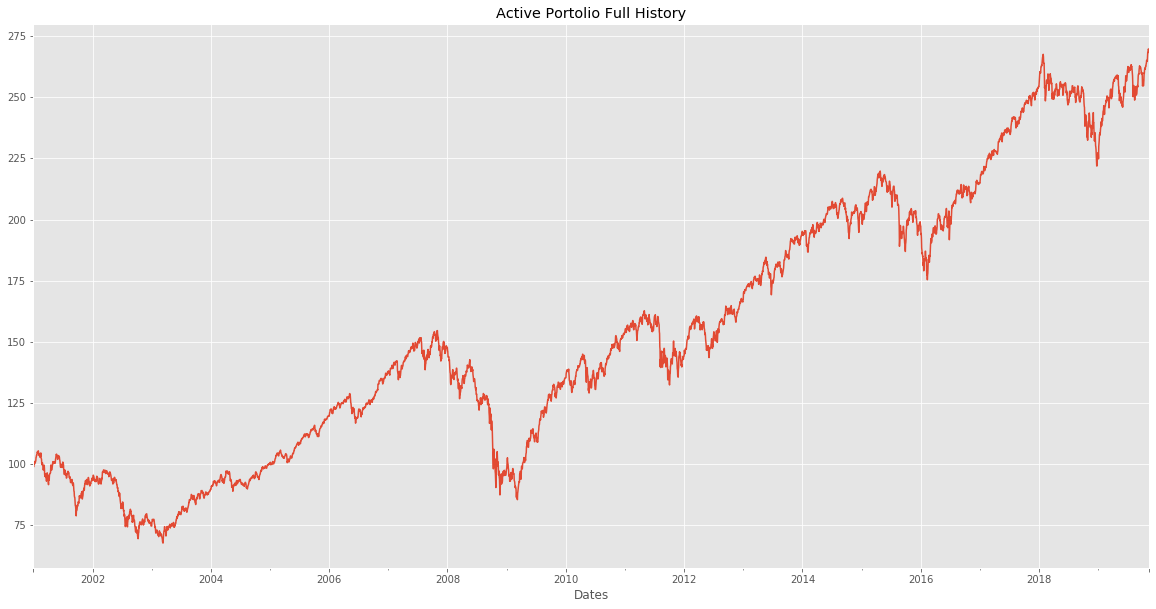

In [14]:
print("Calculating Trend and Volatility based signals for dynamic multiplier TIPPs...")

# Trend-based parameters
short_window=20
long_window=120
observation_window=5
risk_free_r=-0.003

perf_rets=mf_rets.multiply(TIPP_des['Weight']).sum(axis=1)
perf_nav = 100*(1+perf_rets).cumprod()
perf_nav.plot(figsize=(20,10),title="Active Portolio Full History")
market=pd.DataFrame(index=perf_nav.index,columns=['Active','MA_short','MA_long','MA_signal'])
market['Active']=perf_nav
market['MA_short']= market['Active'].rolling(short_window).mean()
market['MA_long']= market['Active'].rolling(long_window).mean()
def day_trend(row):
        short_window = row[1]
        long_window = row[2]
        if (short_window>long_window): 
            return 1
        return 0
market['MA_signal']=market.apply(day_trend,axis = 'columns')
market.dropna(inplace=True)
market['MA_signal']=market['MA_signal'].rolling(observation_window).sum()
market.dropna(inplace=True)
market=market.join(other_prices['VIX Index'],how='left')
market['Const mult']=max_mult
market['MA mult']=market['MA_signal'].apply(ma_multiplier)
market['VIX mult']=market['VIX Index'].apply(vix_multiplier)
market['ActiveRet']= market['Active'].pct_change()
market['SafeRet']=risk_free_r/250

#market.head()
print("Done...\n All signals can be found in the 'market' dataframe")
#market['MA mult'].plot(figsize=(20,5))
# market

In [ ]:
def backtesting(length = 1,fname='results'):
    simulation_results= pd.DataFrame(index=market.index,columns=['Active','Trend','CM','VIX','Trend_lock','CM_lock','VIX_lock','Trend_exposure','CM_exposure','VIX_exposure'])
    prev_date=simulation_results.index[0]
    for start_dt in market.index[:length]:
        dformat="%Y-%m-%d"
        start_dt=datetime.strftime(start_dt,dformat)
        sim,locked,exposure = simulate_TIPP_MA(start_date=start_dt,fees=0.02)
        last_date=sim.index[-1]
        sim=sim.join(market['ActiveRet'],how='left')
        sim['Active']=100*(1+sim['ActiveRet']).cumprod()
        sim.loc[start_dt,'Active']=100
        simulation_results.loc[start_dt,'Active']=sim.loc[last_date,'Active']
        simulation_results.loc[start_dt,'Trend']=sim.loc[last_date,'TIPP_NAV']/100-1
        simulation_results.loc[start_dt,'Trend_lock']=locked
        simulation_results.loc[start_dt,'Trend_exposure']=exposure
   
        sim,locked,exposure = simulate_TIPP_CM(start_date=start_dt,fees=0.02)
        simulation_results.loc[start_dt,'CM']=sim.loc[last_date,'TIPP_NAV']/100-1
        simulation_results.loc[start_dt,'CM_lock']=locked
        simulation_results.loc[start_dt,'CM_exposure']=exposure
    
        sim,locked1,exposure = simulate_TIPP_VOL(start_date=start_dt,fees=0.02)
        simulation_results.loc[start_dt,'VIX']=sim.loc[last_date,'TIPP_NAV']/100-1
        simulation_results.loc[start_dt,'VIX_lock']=locked
        simulation_results.loc[start_dt,'VIX_exposure']=exposure
        simulation_results.to_csv(fname+'.csv')
  

## Backtesting TIPP strategy for a specific past date
User inputs a start date from backtesting. The backtesting runs for a period of maximum 5 years or until the last availalable data point if less than 5 years. 

Maximum allocation to active portfolio = $\max\{0\%,\min[100\%,\text{Maximum Multilier}\times \text{Cushion}]\}$

Cushion = $1-\frac{(PA_t+Fees)}{NAV_t}$ where $PA_t$ is the Protected Amount in respect of such Calculation Date, $NAV_t$ is the Protected Fund Unit NAV in respect of the current Calculation Date. $Fees$ s the aggregate present value of any fees per Unit of the Protected Fund to be deducted from the net asset value of the Protected Fund that are deemed necessary to protect by the Allocation Advisor (see “Other Costs”), including any guaranteed Investment Management
Fee or Other Costs to be deducted following the Maximum Allocation to Active Portfolio being set to zero;

In [15]:
start_dt=input("Enter a past date (after 2001-06-21, use yyyy-mm-dd format) to test the TIPP fund:")
#start_dt='2001-06-21'
start_dt=datetime.strptime(start_dt,"%Y-%m-%d")
#start_dt='2014-05-23'
wd=start_dt.weekday()
while (wd>=5):
    start_dt=start_dt+timedelta(days=1)
    wd=start_dt.weekday()

start_dt=datetime.strftime(start_dt,"%Y-%m-%d")
print("Start Date:{0}".format(start_dt))

Enter a past date (after 2001-06-21, use yyyy-mm-dd format) to test the TIPP fund: 2016-07-21


Start Date:2016-07-21


In [18]:
print("Processing, please wait ...")
st=time.time()
sim_MA,locked_MA,exposure_MA = simulate_TIPP_MA(start_date=start_dt,fees=0.02)
sim_CM,locked_CM,exposure_CM = simulate_TIPP_CM(start_date=start_dt,fees=0.02)
sim_VOL,locked_VOL,exposure_VOL = simulate_TIPP_VOL(start_date=start_dt,fees=0.02)
en=time.time()
print("Done! Caclulation completed in {0:.1f} secs".format((en-st)))

sim=pd.DataFrame(index=sim_MA.index)
sim['TIPP_Trend']=sim_MA['TIPP_NAV']
sim['Trend_protection']=sim_MA['Protected_NAV']
sim['Trend_cushion']=sim_MA['Cushion']
sim['Trend_exposure']=sim_MA['Active_w']

sim['TIPP_CM']=sim_CM['TIPP_NAV']
sim['CM_protection']=sim_CM['Protected_NAV']
sim['CM_cushion']=sim_CM['Cushion']
sim['CM_exposure']=sim_CM['Active_w']

sim['TIPP_VOL']=sim_VOL['TIPP_NAV']
sim['VOL_protection']=sim_VOL['Protected_NAV']
sim['VOL_cushion']=sim_VOL['Cushion']
sim['VOL_exposure']=sim_VOL['Active_w']

sim=sim.join(market['ActiveRet'],how='left')
sim['Active']=100*(1+sim['ActiveRet']).cumprod()
sim.loc[start_dt,'Active']=100

Processing, please wait ...
Done! Caclulation completed in 9.7 secs


Active Portfolio's Maximum drawdown for the period starting from 2016-07-21 and for 5yrs max is:-17.1%



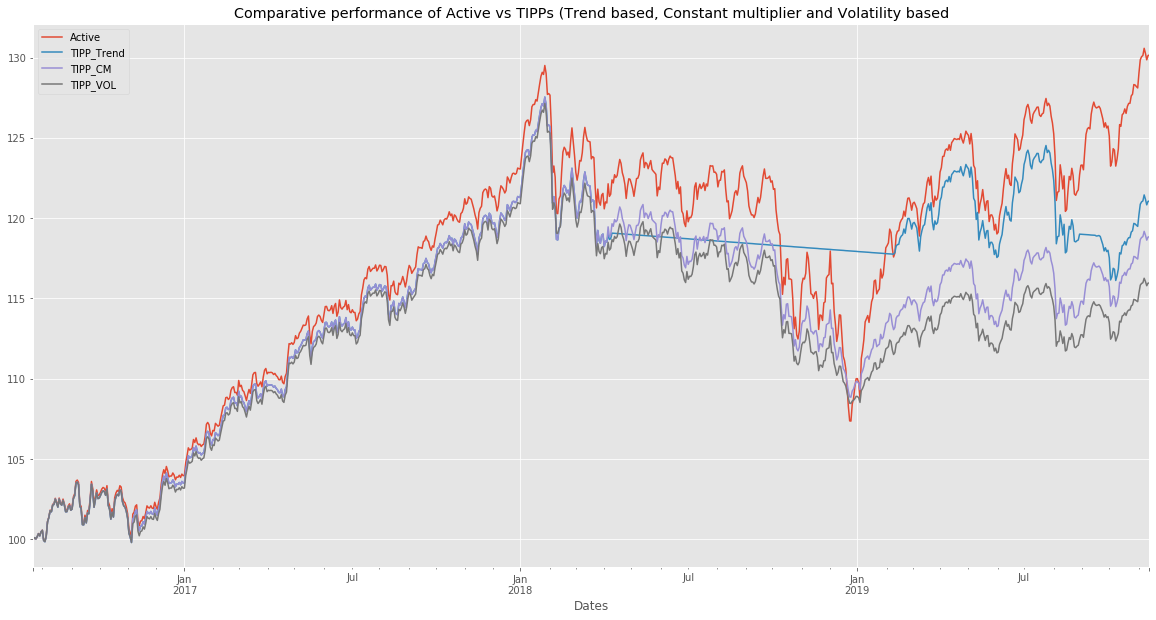

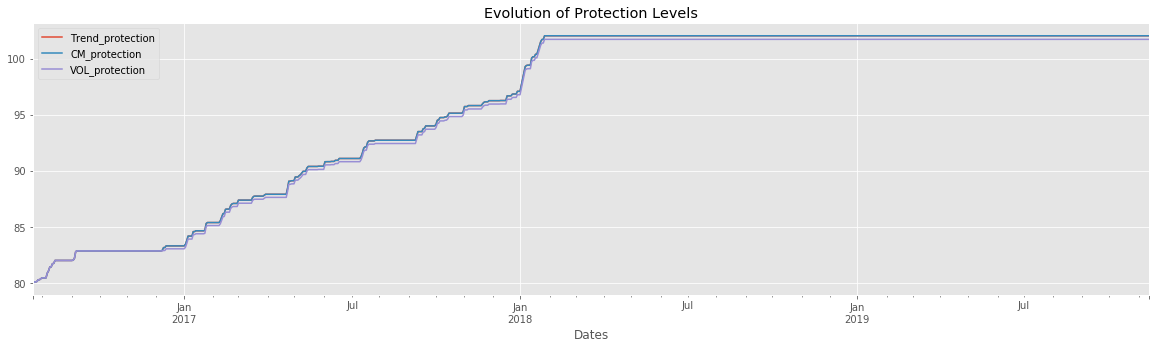

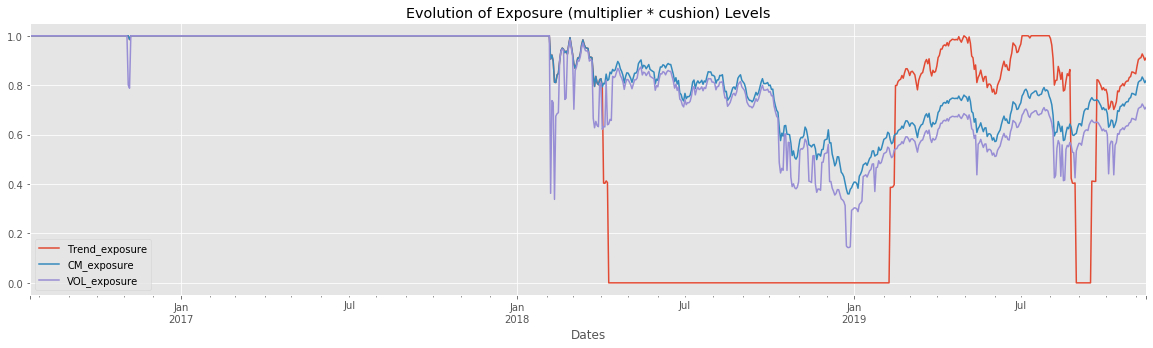

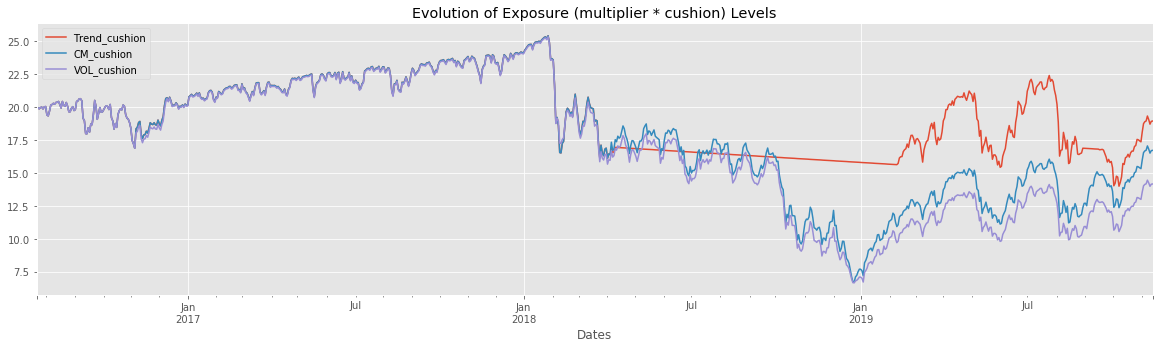

In [19]:
sim.plot(y=['Active','TIPP_Trend','TIPP_CM','TIPP_VOL'],figsize=(20,10),
         title="Comparative performance of Active vs TIPPs (Trend based, Constant multiplier and Volatility based")
#sim.plot(y=['Active_w'],figsize=(20,5))
sim.plot(y=['Trend_protection','CM_protection','VOL_protection'],figsize=(20,5),
         title="Evolution of Protection Levels")
sim.plot(y=['Trend_exposure','CM_exposure','VOL_exposure'],figsize=(20,5),
         title="Evolution of Exposure (multiplier * cushion) Levels")
sim.plot(y=['Trend_cushion','CM_cushion','VOL_cushion'],figsize=(20,5),
         title="Evolution of Exposure (multiplier * cushion) Levels")
print("Active Portfolio's Maximum drawdown for the period starting from {0} and for 5yrs max is:{1:.1f}%\n".format(start_dt,100*max_drawdown(sim['Active'])))
#sim.tail(1)